<a href="https://colab.research.google.com/github/rizkiar00/Q-Learning/blob/master/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
np.set_printoptions(threshold=100000)
import seaborn as sns; sns.set()

In [0]:
from google.colab import files
!git clone https://github.com/rizkiar00/Q-Learning

Cloning into 'Q-Learning'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


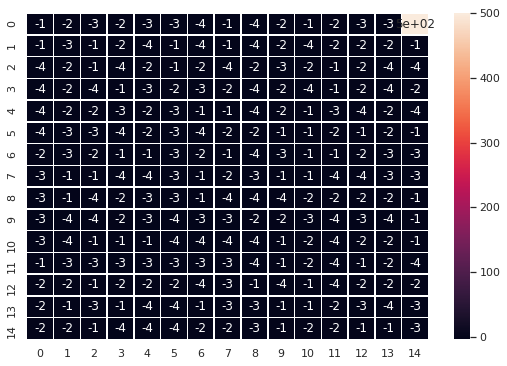

In [0]:
my_data = np.genfromtxt('Q-Learning/DataTugas3ML2019.txt', delimiter = '\t')

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(my_data, annot=True, linewidths=.5, ax=ax)

In [0]:
#@title Default title text
def build_R(rw):
    xlen = len(rw)
    ylen = len(rw[0])

    d = pd.DataFrame(columns = ['up', 'right', 'down', 'left', 'this'])
    idx = 0 
    
    for i in range(ylen):
        for j in range(xlen):
            move = [float('-inf'),float('-inf'),float('-inf'),float('-inf'), rw[i][j]]
            if i>0: #up
                move[0] = rw[i-1][j]
            if i<ylen-1: #down
                move[2] = rw[i+1][j]
            if j>0: #left
                move[3] = rw[i][j-1]
            if j<xlen-1: #right
                move[1] = rw[i][j+1]
            d.loc[idx] = move
            idx+=1
    return d

R = build_R(my_data)
R = np.array(R)
print(R)

[[-inf  -2.  -1. -inf  -1.]
 [-inf  -3.  -3.  -1.  -2.]
 [-inf  -2.  -1.  -2.  -3.]
 ...
 [ -3.  -1. -inf  -2.  -1.]
 [ -4.  -3. -inf  -1.  -1.]
 [ -3. -inf -inf  -1.  -3.]]


In [0]:
def build_trans(rw):
    xlen = len(rw)
    ylen = len(rw[0])
    
    d = {'up':[] ,'right':[], 'down':[], 'left':[]}
    d = pd.DataFrame(columns = ['up', 'right', 'down', 'left', 'none'])
    idx = 0 
    
    for i in range(ylen):
        for j in range(xlen):
            trans = [-1,-1,-1,-1, idx]
            if i>0: #up
                trans[0] = idx-xlen
            if i<ylen-1: #down
                trans[2] = idx+xlen
            if j>0: #left
                trans[3] = idx-1
            if j<xlen-1: #right
                trans[1] = idx+1
            d.loc[idx] = trans
            idx+=1
    return d
trans = build_trans(my_data)
trans = np.array(trans)
trans

array([[-1, 1, 15, -1, 0],
       [-1, 2, 16, 0, 1],
       [-1, 3, 17, 1, 2],
       ...,
       [207, 223, -1, 221, 222],
       [208, 224, -1, 222, 223],
       [209, -1, -1, 223, 224]], dtype=object)

In [0]:
def build_va(trans):
    va = []
    for i in range(len(trans)):
        current_va = []
        if (trans[i][0] != -1): #up
            current_va.append(0)
        if (trans[i][1] != -1): #right
            current_va.append(1)
        if (trans[i][2] != -1): #down
            current_va.append(2)
        if (trans[i][3] != -1): #left
            current_va.append(3)
        current_va.append(4)
        va.append(current_va)
    return va
va = build_va(trans)
va = np.array(va)
va

array([list([1, 2, 4]), list([1, 2, 3, 4]), list([1, 2, 3, 4]),
       list([1, 2, 3, 4]), list([1, 2, 3, 4]), list([1, 2, 3, 4]),
       list([1, 2, 3, 4]), list([1, 2, 3, 4]), list([1, 2, 3, 4]),
       list([1, 2, 3, 4]), list([1, 2, 3, 4]), list([1, 2, 3, 4]),
       list([1, 2, 3, 4]), list([1, 2, 3, 4]), list([2, 3, 4]),
       list([0, 1, 2, 4]), list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 2, 3, 4]), list([0, 1, 2, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4]),
       list([0, 1, 2, 3, 4]), list([0, 1, 2, 3, 4])

In [0]:
Q = np.full((225, 5), -100)
alfa = 0.2 #Learning Rate
gamma = 0.9 #Discount Factor
episodes = 1000
reward_list = []
bestreward = -100
for i in range(episodes):
    #start = 210
    start_state = random.randint(0,224)
    goal_state = 14
    current_state = start_state
    current_reward = R[current_state][4]
#     liststate = []
#     listaction = []
#     beststate = []
#     bestaction = []
    while current_state != goal_state:
        action = random.choice(va[current_state])
        next_state = trans[current_state][action]
        future_rewards = []
        for action_nxt in va[next_state]:
            future_rewards.append(Q[next_state][action_nxt])
#         liststate.append(current_state)
#         listaction.append(action)
        #update Q
        #print('CS : {}\nAct : {}'.format(current_state, action))
        qstate = Q[current_state][action]+alfa*(R[current_state][action] + gamma*max(future_rewards)-Q[current_state][action])
        Q[current_state][action] = qstate
        #print(Q)
        current_state = next_state
        current_reward += R[current_state][4]
        if(current_state == goal_state) and ((i+1) % 100 == 0):
            print('Episode {}, score : {}'.format(i, current_reward))
            reward_list.append(current_reward)
#             if(bestreward<current_reward):
#               beststate = liststate
#               bestaction = listaction

Episode 99, score : -687.0
Episode 199, score : -3297.0
Episode 299, score : 334.0
Episode 399, score : -99.0
Episode 499, score : -10423.0
Episode 599, score : -3958.0
Episode 699, score : -4408.0
Episode 799, score : -2727.0
Episode 899, score : -3697.0
Episode 999, score : -6127.0


In [0]:
Q

array([[-100,   51,   31, -100,   40],
       [-100,   64,   41,   40,   51],
       [-100,   79,   54,   51,   64],
       ...,
       [  33,   32, -100,   15,   24],
       [  42,   40, -100,   24,   32],
       [  53, -100, -100,   32,   40]])

In [0]:
# for i in range(len(Q)):
#   for j in range(5):
#     if(Q[i][j]==0):
#       Q[i][j]=-100
      
start_state = 210
goal_state = 14
current_state = start_state
liststate = []
listaction = []
current_reward = R[current_state][4]
while current_state != goal_state:
  action = np.argmax(Q[current_state][0:2])
  current_state = trans[current_state][action]
  current_reward += R[current_state][4]
  liststate.append(current_state)
  listaction.append(action)
  print('current_state: ', current_state)
print('Reward: ', current_reward)

current_state:  195
current_state:  196
current_state:  181
current_state:  182
current_state:  167
current_state:  152
current_state:  153
current_state:  138
current_state:  123
current_state:  124
current_state:  125
current_state:  126
current_state:  111
current_state:  96
current_state:  97
current_state:  82
current_state:  83
current_state:  84
current_state:  85
current_state:  70
current_state:  71
current_state:  56
current_state:  41
current_state:  26
current_state:  27
current_state:  28
current_state:  29
current_state:  14
Reward:  453.0


J:0 K:14
J:14 K:0


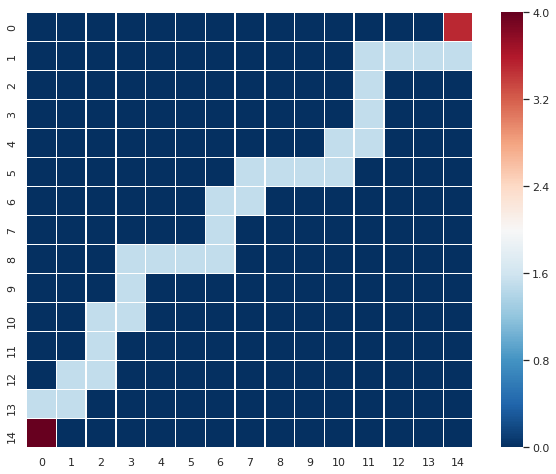

In [0]:
point = np.zeros((15,15))
i = 0
for j in range(15):
  for k in range(15):
    point[j][k] = liststate.count(i)*1.5
    if (i == 14):
      point[j][k] += 2
      print('J:{} K:{}'.format(j,k))    
    if (i == 210):
      point[j][k] += 4
      print('J:{} K:{}'.format(j,k))
    i += 1
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(point,linewidths=.5,cmap="RdBu_r")